In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM 

from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Configs

In [2]:
tf.random.set_seed(96)

dataset_path = "TSLA.csv"
train_test_split = 0.90
window_size = 10
batch_size = 32
epochs = 25

open_column = "Open"
close_column = "Close"
date_column = "Date"
high_column = "High"
low_column = "Low"
volume_column = "Volume"

## Import Dataset

In [3]:
df = pd.read_csv(dataset_path)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [4]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
df[date_column] = pd.to_datetime(df[date_column])

## Graphs and Correlation Matrix

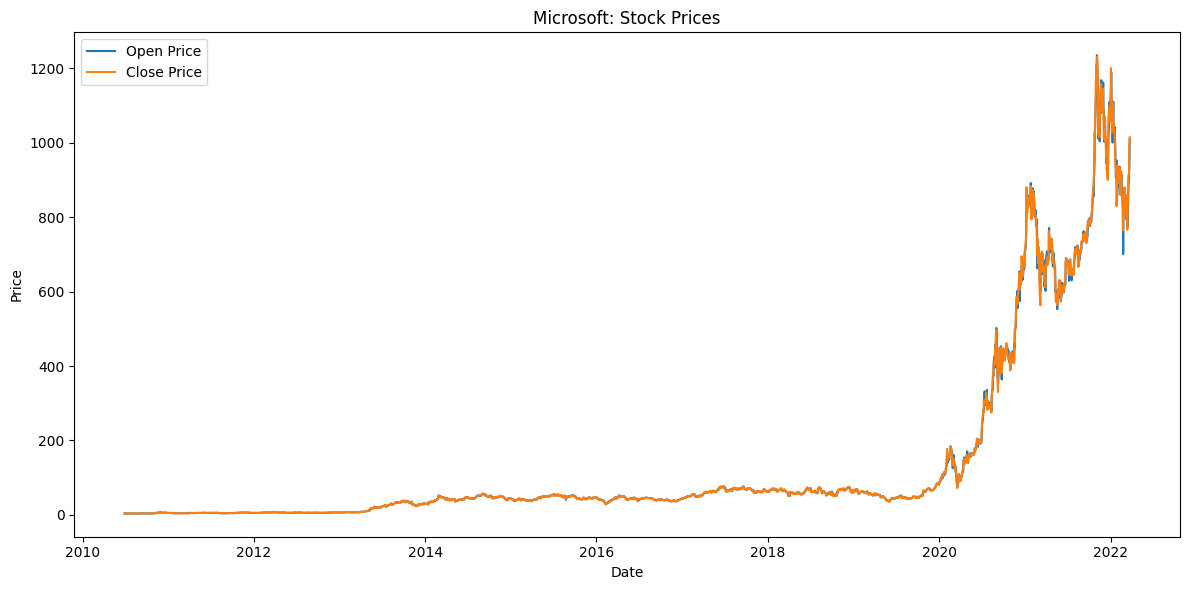

In [6]:
plt.figure(figsize=(12, 6))
plt.title('Microsoft: Stock Prices')
plt.plot(df[date_column], df[open_column], label='Open Price')
plt.plot(df[date_column], df[close_column], label='Close Price')
plt.xlabel(date_column)
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

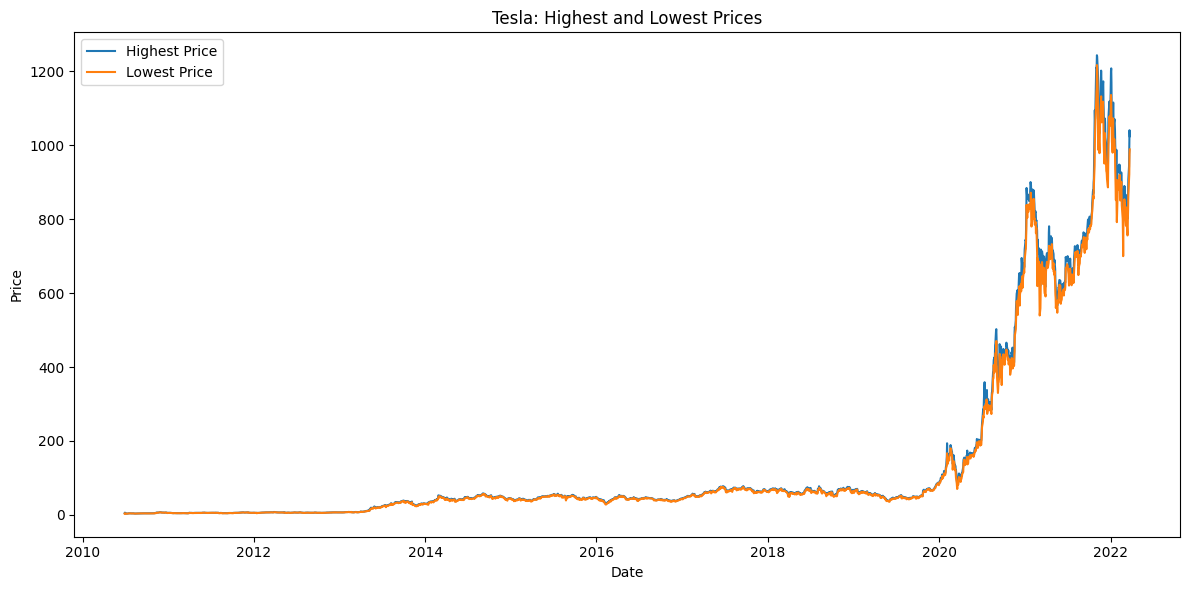

In [7]:
plt.figure(figsize=(12, 6))
plt.title('Tesla: Highest and Lowest Prices')
plt.plot(df[date_column], df[high_column], label='Highest Price')
plt.plot(df[date_column], df[low_column], label='Lowest Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

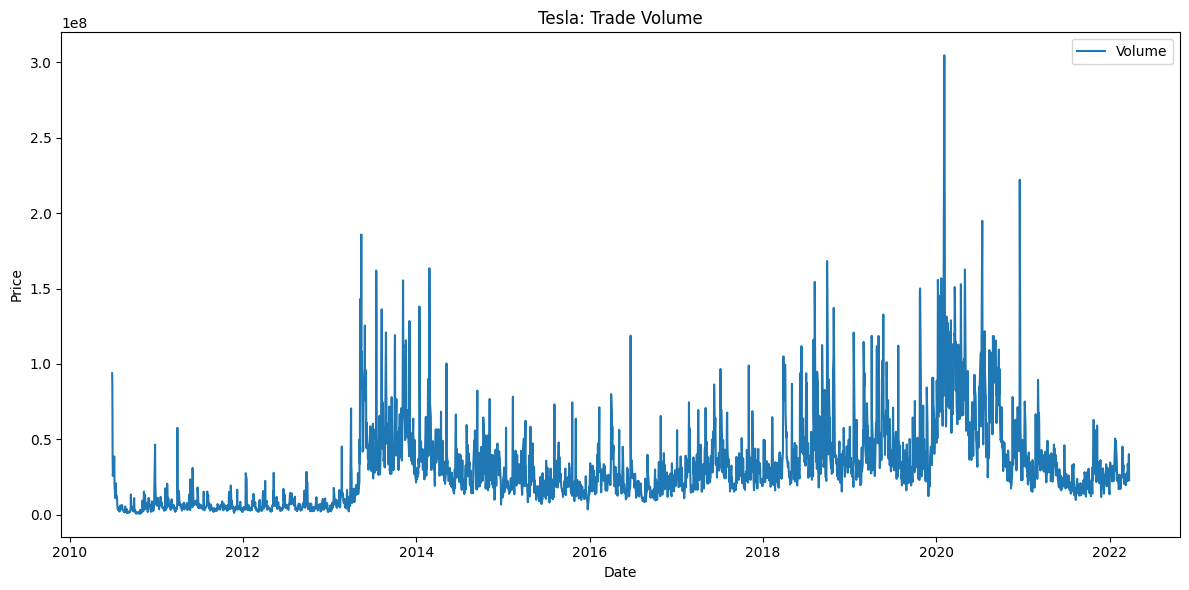

In [8]:
plt.figure(figsize=(12, 6))
plt.title('Tesla: Trade Volume')
plt.plot(df[date_column], df[volume_column], label='Volume')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
numeric_df.head()

,Open,High,Low,Close,Adj Close,Volume
0,3.800,5.000,3.508,4.778,4.778,93831500
1,5.158,6.084,4.660,4.766,4.766,85935500
2,5.000,5.184,4.054,4.392,4.392,41094000
3,4.600,4.620,3.742,3.840,3.840,25699000
4,4.000,4.000,3.166,3.222,3.222,34334500


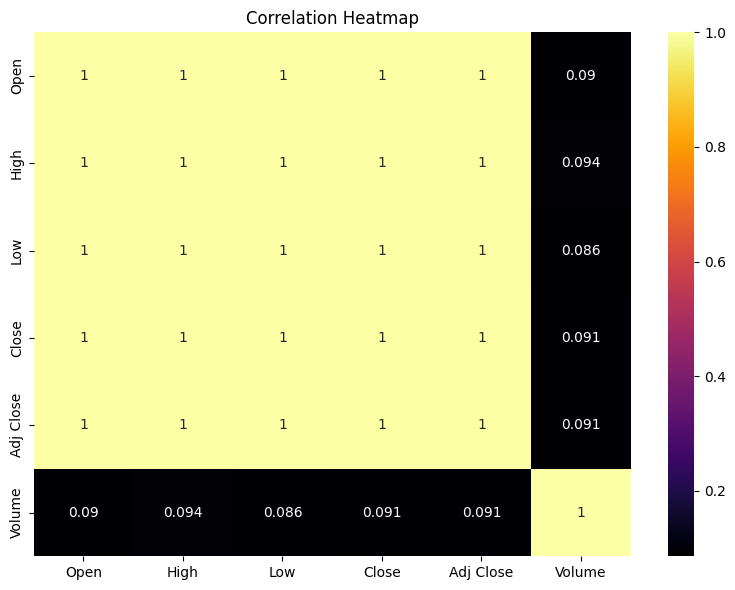

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='inferno')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

## Scale Data

In [11]:
stock_close = df[close_column].values

In [12]:
training_data_len = int(np.ceil(train_test_split * len(stock_close)))

dataset = stock_close.reshape(-1, 1)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

scaled_train = scaled_data[:training_data_len]

In [13]:
scaled_train.shape

(2661, 1)

## Provide Context to train LSTM

In [14]:
def create_sliding_window(data, window_size):
    X, y = [], []
    
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    
    return np.array(X), np.array(y).reshape(-1)

In [15]:
X_train, y_train = create_sliding_window(scaled_train, window_size)

In [16]:
X_train.shape, y_train.shape

((2651, 10, 1), (2651,))

## Build Model

In [17]:
model = Sequential(name="StockPriceLSTM")
model.add(keras.Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.summary()
model.compile(optimizer="adam", loss="mae", metrics=["root_mean_squared_error"])

Model: "StockPriceLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [18]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1788 - root_mean_squared_error: 0.2987
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0610 - root_mean_squared_error: 0.1063
Epoch 3/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0577 - root_mean_squared_error: 0.0983
Epoch 4/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0525 - root_mean_squared_error: 0.1000
Epoch 5/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0514 - root_mean_squared_error: 0.0994
Epoch 6/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0508 - root_mean_squared_error: 0.0900
Epoch 7/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0529 - root_mean_squared_error: 0.1004
Epoch 8/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0470 - root_mean_squared_error: 0.0898
Epoch 9/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0469 - root_mean_squared_error: 0.0980
Epoch 10/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0439 - root_mean_squared_error: 0.0896
Epoch 11/

## Training History Graphs

In [19]:
def generate_history_graph(history):
    metrics = list(history.history.keys())
    num_metrics = len(metrics)
    
    plt.figure(figsize=(8*num_metrics, 6))
    
    for idx, metric in enumerate(metrics, 1):
        plt.subplot(1, num_metrics, idx)
        plt.plot(history.history[metric], label=metric)
        plt.title(f"{metric} over Epochs")
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

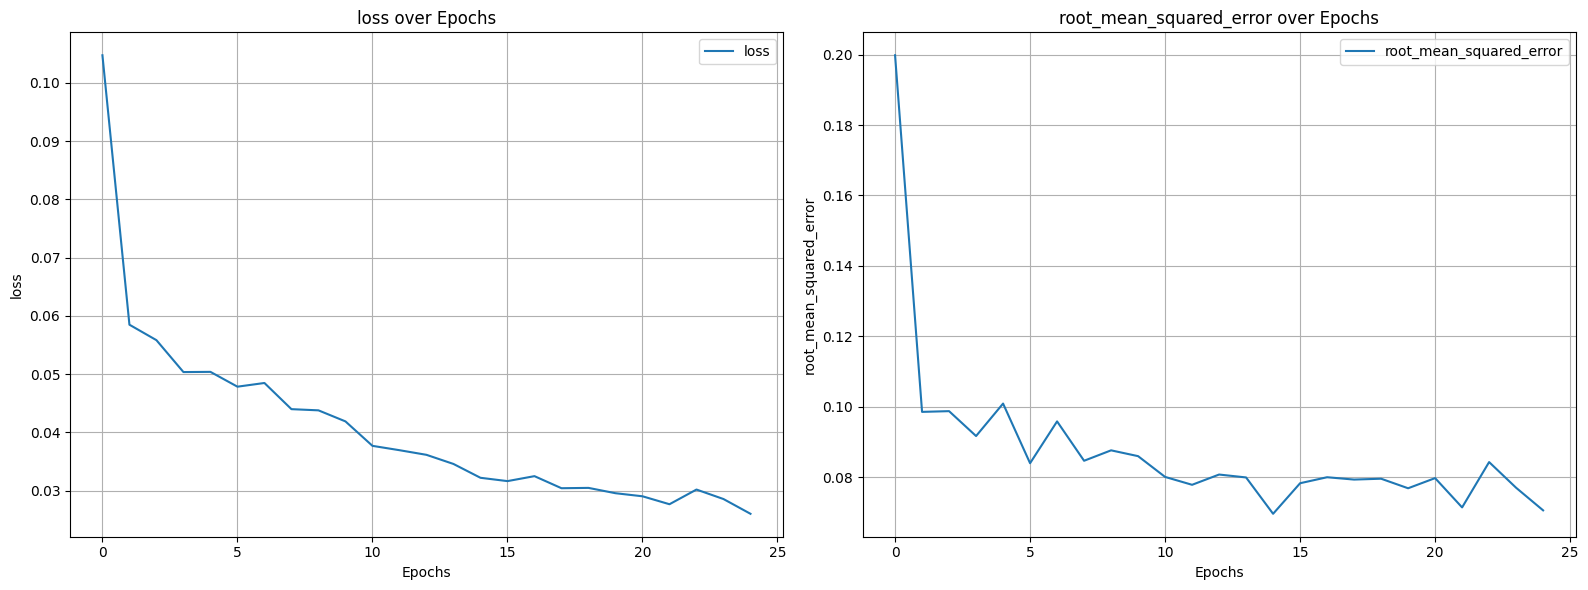

In [20]:
generate_history_graph(history)

## Save Model

In [21]:
import joblib

joblib.dump(scaler, 'scaler.pkl')
model.save("StockPriceLSTM.keras")

## Model Testing

### Prepare X_test

In [22]:
test_data = scaled_data[training_data_len - 60:]
X_test = []

X_test, _ = create_sliding_window(test_data, 60)

In [23]:
len(test_data), X_test.shape

(355, (295, 60, 1))

### Prediction

In [24]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


### Visualization

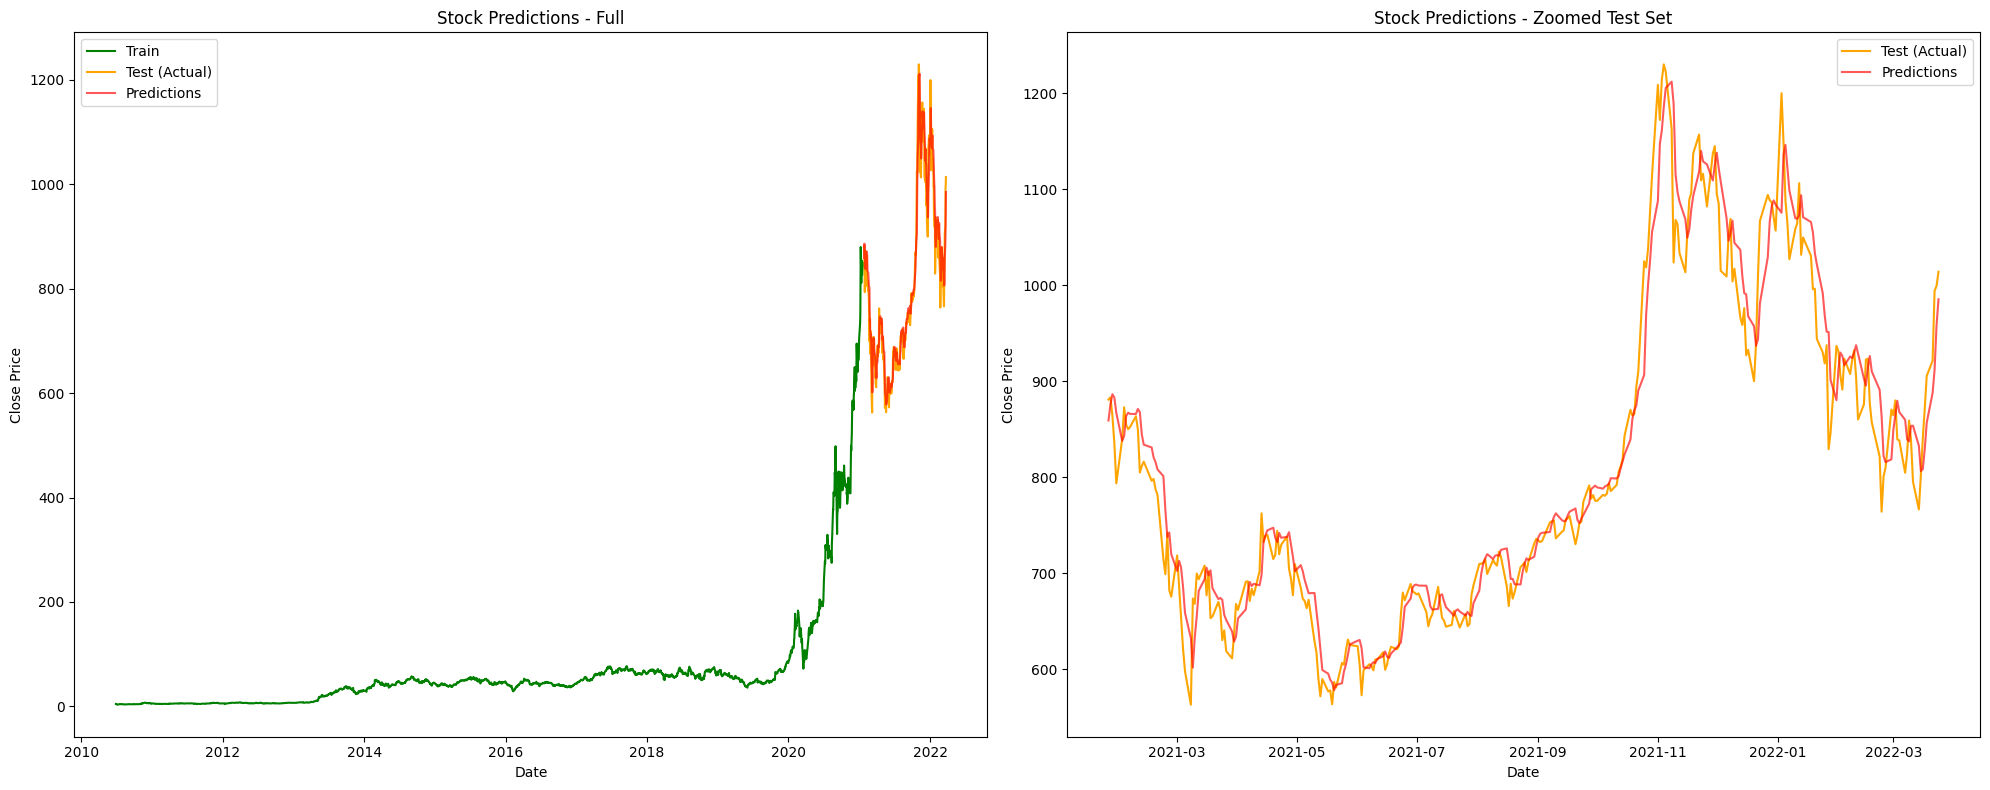

In [31]:
train = df[:training_data_len]
test = df[training_data_len:].copy()
test['Predictions'] = predictions

plt.figure(figsize=(20, 8))

# Full View: Train + Test + Predictions
plt.subplot(1, 2, 1)
plt.plot(train[date_column], train[close_column], label="Train", color='green')
plt.plot(test[date_column], test[close_column], label="Test (Actual)", color='orange')
plt.plot(test[date_column], test['Predictions'], label="Predictions", color='red', alpha=0.65)
plt.title("Stock Predictions - Full")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()

# Zoomed View: Test vs Predictions
plt.subplot(1, 2, 2)
plt.plot(test[date_column], test[close_column], label="Test (Actual)", color='orange')
plt.plot(test[date_column], test['Predictions'], label="Predictions", color='red', alpha=0.65)
plt.title("Stock Predictions - Zoomed Test Set")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()

plt.tight_layout()
plt.show()